##### This notebook will be used to `convert the video data (landmarks) into numpy files`. We also include `data augmentation` in the process via `horizontal flipping` (left/right handed signers) and `zooming-in`. The steps are as follows:

1. `Install` Dependencies
2. `Call functions` for All Augmentation Techniques (Flipping, Zooming, Affine, RTM, etc.)
3. `Setup Folders` for Collection
4. `Collect Landmarks` per frame for Training and Testing. `Store` them as numpy files in DATA_PATH, FLIPPED_DATA_PATH and ZOOMED_DATA_PATH, etc. 
5. `Converge DATA_PATH folders into new_folder.`  

1. `Install` Dependencies

In [1]:
# %pip install tensorflow==2.6 opencv-python mediapipe==0.9.1.0 scikit-learn matplotlib
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import os
import mediapipe as mp

2. Call functions for:   
`Drawing/Extracting` landmarks using `MP Holistic`,  
`Zooming in` on the image for `data augmentation`,  
`Plotting` the images for `visualization`.

In [2]:
# Keypoints Portion
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def draw_landmarks(image, results):
   #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
    
def draw_styled_landmarks(image, results):
    # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )
    
#Extracting Keypoints into a numpy array
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4) 
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh]) # single row of data for each image

Functions for augmentation.

In [20]:
import random
import numpy as np

# Random Temporal Masking
def random_temporal_mask(frame, current_frame_num, mask_frames):
    if current_frame_num in mask_frames:
        return np.zeros_like(frame)
    return frame

# Fixed Interval Masking
def fixed_interval_mask(frame, current_frame_num, interval=5):
    if current_frame_num % interval == 0:
        return np.zeros_like(frame)
    return frame

# End-of-Sequence Masking
def end_sequence_mask(frame, current_frame_num, sequence_length, mask_length=5):
    if current_frame_num >= sequence_length - mask_length:
        return np.zeros_like(frame)
    return frame

# Random Single Frame Masking
def random_single_frame_mask(frame, current_frame_num, mask_frames):
    return random_temporal_mask(frame, current_frame_num, mask_frames)

# Function for zooming image by 1.2x
def zoom_frame(image, zoom, angle=0, coord=None):
    
    cy, cx = [ i/2 for i in image.shape[:-1] ] if coord is None else coord[::-1] # Centered at "coord", if given, else the image center.
    
    rot_mat = cv2.getRotationMatrix2D((cx,cy), angle, zoom) # Rotation matrix.
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR) 
    
    return result

def temporal_mask(frames, mask_start, mask_end):
    blank_frame = np.zeros_like(frames[0])
    for i in range(mask_start, mask_end):
        frames[i] = blank_frame
    return frames

def apply_affine_transform(image, angle=0, scale=1, tx=0, ty=0):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, scale)
    M[0, 2] += tx  # Horizontal shift
    M[1, 2] += ty  # Vertical shift
    return cv2.warpAffine(image, M, (cols, rows))

def shift_sequence(frames, shift_count=5):
    blank_frame = np.zeros_like(frames[0])
    # Add blank frames at the beginning
    for _ in range(shift_count):
        frames.insert(0, blank_frame)
    return frames


# Plot the images
def plot_images(*images, titles):
    # Determine the number of images
    n = len(images)

    # Create subplots
    plt.figure(figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images, titles), start=1):
        plt.subplot(1, n, i)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.title(title)
        plt.axis('off')

    plt.show()

3. `Setup Folders` for Collection

In [ ]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('DATA/raw_keypoints') 
FLIPPED_DATA_PATH = os.path.join('DATA/flipped_keypoints')
ZOOMED_DATA_PATH = os.path.join('DATA/zoomed_keypoints')
ZOOMED2_DATA_PATH = os.path.join('DATA/zoomed2_keypoints')
ZOOMED3_DATA_PATH = os.path.join('DATA/zoomed3_keypoints')
AFFLINE_DATA_PATH = os.path.join('DATA/affline_keypoints')
RTM_DATA_PATH = os.path.join('DATA/rtm_keypoints')
FIM_DATA_PATH = os.path.join('DATA/fim_keypoints')
ESM_DATA_PATH = os.path.join('DATA/esm_keypoints')
RSM_DATA_PATH = os.path.join('DATA/rsm_keypoints')

# Actions that we try to detect
actions = np.array(['ako',  'bakit', 'F', 'hi', 'hindi', 'ikaw',  'kamusta', 'L', 'maganda', 'magandang umaga', 'N', 'O', 'oo', 'P', 'salamat'])

# number of videos we want to use for training
no_sequences = 14

# Videos are going to be 30 frames in length
sequence_length = 30

# Define input directories
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
            os.makedirs(os.path.join(FLIPPED_DATA_PATH, action, str(sequence)))
            os.makedirs(os.path.join(ZOOMED_DATA_PATH, action, str(sequence)))
            os.makedirs(os.path.join(ZOOMED2_DATA_PATH, action, str(sequence)))
            os.makedirs(os.path.join(ZOOMED3_DATA_PATH, action, str(sequence)))
            os.makedirs(os.path.join(AFFLINE_DATA_PATH, action, str(sequence)))
            os.makedirs(os.path.join(RTM_DATA_PATH, action, str(sequence)))
            os.makedirs(os.path.join(FIM_DATA_PATH, action, str(sequence)))
            os.makedirs(os.path.join(ESM_DATA_PATH, action, str(sequence)))
            os.makedirs(os.path.join(RSM_DATA_PATH, action, str(sequence)))
        except:
            pass

4. `Collect Landmarks` for Training and Testing. `Store` them as numpy files in DATA_PATH.

[ WARN:0@1758.623] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@1758.624] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin7 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@1758.624] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@1758.624] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/v

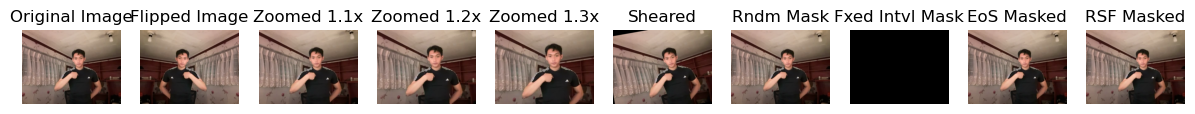

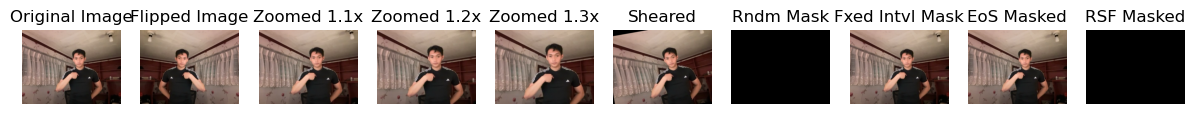

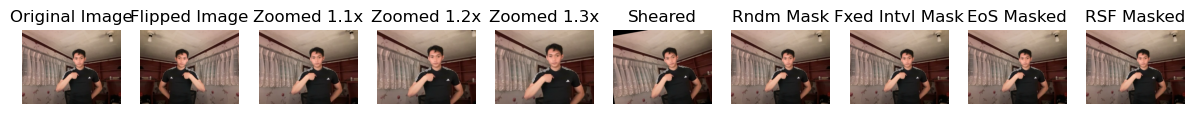

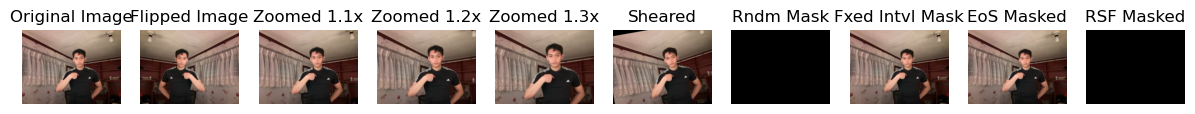

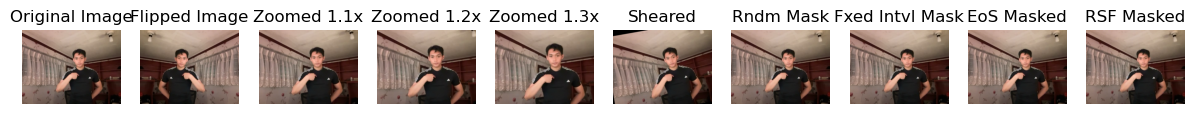

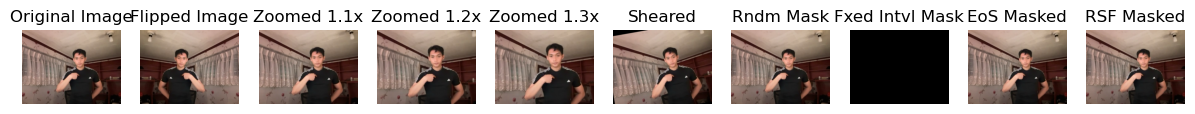

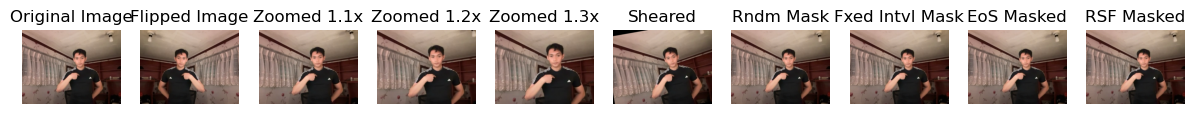

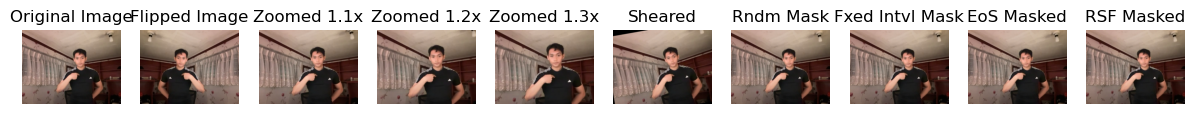

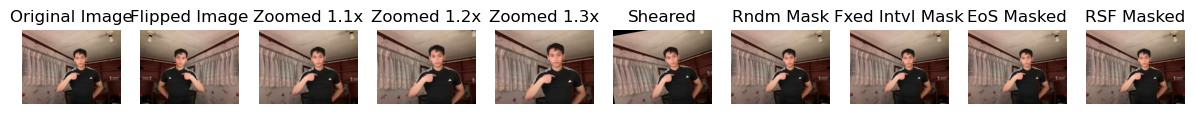

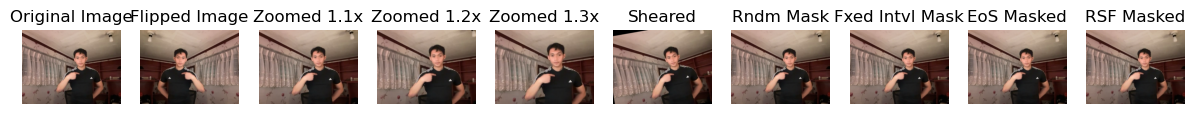

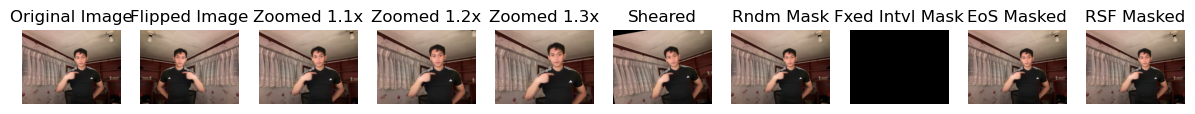

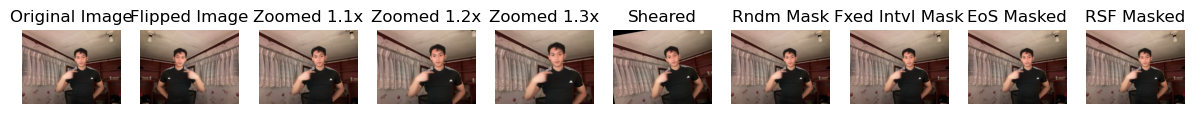

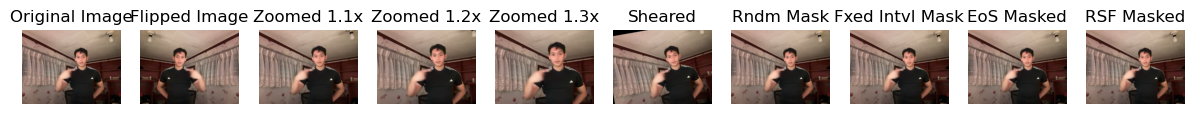

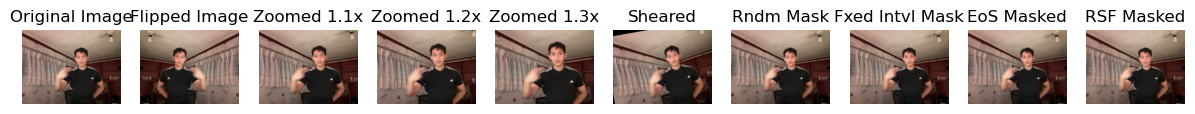

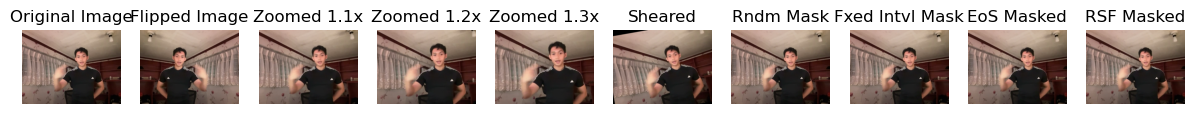

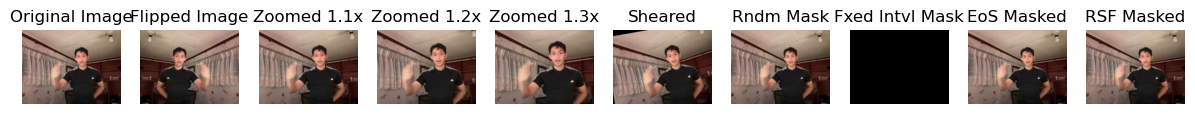

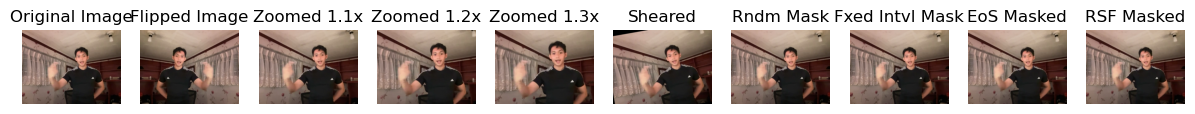

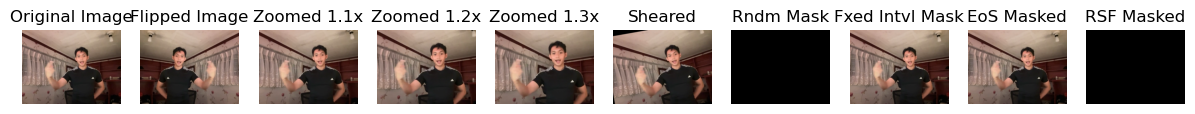

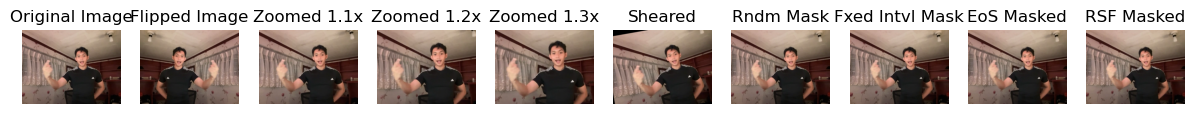

KeyboardInterrupt: 

In [19]:
# Set up Mediapipe Holistic model
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

input_dir = '../../videos/signed_videos'

# Define augmentation parameters (modify these as needed)
sequence_length = 30
random_mask_frames = random.sample(range(sequence_length), 5)  # 5 random frames
varying_mask_ranges = [(6, 8), (15, 18)]  # Example ranges
zoom_factor = 1.2
angle = 10  # Degrees for rotation
scale = 1.1 # Scaling factor
tx, ty = 10, 10 # Translation in pixels
shift_count = 5 # Number of frames to shift
mask_start, mask_end = 3, 5 # Start and end frame for temporal masking

# Loop through actions
for action in actions:
    # Loop through sequences
    filename_action = os.path.join(input_dir, action)
    # no_sequences = the number of files in filename_action
    # no_sequences = len([name for name in os.listdir(filename_action) if os.path.isfile(os.path.join(filename_action, name))])
    for sequence in range(no_sequences):       
        filename = os.path.join(input_dir, action, '{}.mp4'.format(sequence))
        cap = cv2.VideoCapture(filename) # Open video file
        # Loop through sequence length
        
        for frame_num in range(sequence_length):
            # Loop through video frames
            # Read video frame
            ret, frame = cap.read()
            zoomed_frame = zoom_frame(frame, zoom=1.1)
            zoomed_frame2 = zoom_frame(frame, zoom=1.2)
            zoomed_frame3 = zoom_frame(frame, zoom=1.3)
            flipped_frame = cv2.flip(frame, 1)
            affine_transformed_frame = apply_affine_transform(frame, angle=10, scale=1.1, tx=10, ty=10)
            rtm_frame = random_temporal_mask(frame, frame_num, random_mask_frames)
            fim_frame = fixed_interval_mask(frame, frame_num)
            esm_frame = end_sequence_mask(frame, frame_num, sequence_length)
            rsm_frame = random_single_frame_mask(frame, frame_num, random_mask_frames)

            if not ret:
                # End of video
                break

            # Make detections
            image, results = mediapipe_detection(frame, holistic)
            zoomed_image, zoomed_results = mediapipe_detection(zoomed_frame, holistic)
            zoomed_image2, zoomed_results2 = mediapipe_detection(zoomed_frame2, holistic)
            zoomed_image3, zoomed_results3 = mediapipe_detection(zoomed_frame3, holistic)
            flipped_image, flipped_results = mediapipe_detection(flipped_frame, holistic)
            affline_image, affline_results = mediapipe_detection(affine_transformed_frame, holistic)
            rtm_image, rtm_results = mediapipe_detection(rtm_frame, holistic)
            fim_image, fim_results = mediapipe_detection(fim_frame, holistic)
            esm_image, esm_results = mediapipe_detection(esm_frame, holistic)
            rsm_image, rsm_results = mediapipe_detection(rsm_frame, holistic)
            
            
            # Draw landmarks
            draw_landmarks(image, results)
            draw_landmarks(flipped_image, flipped_results)
            draw_landmarks(zoomed_image, zoomed_results)
            draw_landmarks(zoomed_image2, zoomed_results2)
            draw_landmarks(zoomed_image3, zoomed_results3)
            draw_landmarks(affline_image, affline_results)
            draw_landmarks(rtm_image, rtm_results)
            draw_landmarks(fim_image, fim_results)
            draw_landmarks(esm_image, esm_results)
            draw_landmarks(rsm_image, rsm_results)
 
            # NEW Export keypoints
            keypoints = extract_keypoints(results)
            flipped_keypoints = extract_keypoints(flipped_results)
            zoomed_keypoints = extract_keypoints(zoomed_results)
            zoomed2_keypoints = extract_keypoints(zoomed_results2)
            zoomed3_keypoints = extract_keypoints(zoomed_results3)
            affline_keypoints = extract_keypoints(affline_results)
            rtm_keypoints = extract_keypoints(rtm_results)
            fim_keypoints = extract_keypoints(fim_results)
            esm_keypoints = extract_keypoints(esm_results)
            rsm_keypoints = extract_keypoints(rsm_results)
            
           
            npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
            flipped_npy_path = os.path.join(FLIPPED_DATA_PATH, action, str(sequence), str(frame_num))
            zoomed_npy_path = os.path.join(ZOOMED_DATA_PATH, action, str(sequence), str(frame_num))
            zoomed2_npy_path = os.path.join(ZOOMED2_DATA_PATH, action, str(sequence), str(frame_num))
            zoomed3_npy_path = os.path.join(ZOOMED3_DATA_PATH, action, str(sequence), str(frame_num))
            rtm_npy_path = os.path.join(RTM_DATA_PATH, action, str(sequence), str(frame_num))
            fim_npy_path = os.path.join(FIM_DATA_PATH, action, str(sequence), str(frame_num))
            esm_npy_path = os.path.join(ESM_DATA_PATH, action, str(sequence), str(frame_num))
            rsm_npy_path = os.path.join(RSM_DATA_PATH, action, str(sequence), str(frame_num))
            affline_npy_path = os.path.join(AFFLINE_DATA_PATH, action, str(sequence), str(frame_num))
            
            np.save(npy_path, keypoints)
            np.save(flipped_npy_path, flipped_keypoints)
            np.save(zoomed_npy_path, zoomed_keypoints)
            np.save(zoomed2_npy_path, zoomed2_keypoints)
            np.save(zoomed3_npy_path, zoomed3_keypoints)
            np.save(affline_npy_path, affline_keypoints)
            np.save(rtm_npy_path, rtm_keypoints)
            np.save(fim_npy_path, fim_keypoints)
            np.save(esm_npy_path, esm_keypoints)
            np.save(rsm_npy_path, rsm_keypoints)
            
            # # Optional: Plot Images
            # plot_images(frame, flipped_frame, zoomed_frame, zoomed_frame2, zoomed_frame3, affine_transformed_frame, rtm_frame, fim_frame, esm_frame, rsm_frame,
            #             titles=['Original Image', 'Flipped Image', 'Zoomed 1.1x','Zoomed 1.2x','Zoomed 1.3x', 'Sheared', 'Rndm Mask', 'Fxed Intvl Mask', 'EoS Masked', 'RSF Masked',])

                
        # Release video file
        cap.release()
cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

5. `Converge DATA_PATH folders into One folder.`  
`Move all the DATA_PATH folders` into a single folder called `MP_Data`. This is done so that the model can be trained on all the data at once.

In [20]:
import os
import shutil

new_folder = 'DATA/NPY_FILES'
folders = [DATA_PATH, FLIPPED_DATA_PATH, ZOOMED_DATA_PATH, ZOOMED2_DATA_PATH, ZOOMED3_DATA_PATH, AFFLINE_DATA_PATH, RTM_DATA_PATH, FIM_DATA_PATH, ESM_DATA_PATH, RSM_DATA_PATH]

if not os.path.exists(new_folder):
    os.makedirs(new_folder)

for folder in folders:
    subdirectories = os.listdir(folder)
    for subdirectory in subdirectories:
        if subdirectory == '.DS_Store':
          continue
        subsubdirectories = os.listdir(os.path.join(folder, subdirectory))
        for subsubdirectory in subsubdirectories:
            src_path = os.path.join(folder, subdirectory, subsubdirectory)
            dst_path = os.path.join(new_folder, subdirectory, subsubdirectory)
            if os.path.exists(dst_path):
                existing_subsubdirectories = [int(name) for name in os.listdir(os.path.join(new_folder, subdirectory))]
                new_subsubdirectory = str(max(existing_subsubdirectories) + 1)
                dst_path = os.path.join(new_folder, subdirectory, new_subsubdirectory)
            if not os.path.exists(dst_path):
                os.makedirs(dst_path)
            for file in os.listdir(src_path):
                shutil.copy2(os.path.join(src_path, file), dst_path)